# **Multiple flipped entries**

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
import math
%matplotlib inline

In [3]:
# Set up the program
reg = QuantumRegister(4, name='reg')
scratch = QuantumRegister(1, name='scratch')
qc = QuantumCircuit(reg, scratch)

In [4]:
def main():
    n2f = [0,1,2]
    number_of_iterations = 5

    qc.h(reg)

    for i in range(number_of_iterations):
        ## Flip the marked value
        qc.barrier()
        for number_to_flip in n2f:
            x_bits = ~number_to_flip
            x_list = [reg[x] for x in range(len(reg)) if x_bits & (1 << x)]
            qc.x(x_list)
            multi_cz([x for x in reg])
            qc.x(x_list)

        qc.barrier()
        Grover(reg)

In [5]:
## Some utility functions

def Grover(qreg, condition_qubits=None):
    if condition_qubits is None:
        condition_qubits = []
    qc.h(qreg)
    qc.x(qreg)
    multi_cz([x for x in qreg] + condition_qubits)
    qc.x(qreg)
    qc.h(qreg)

In [6]:
def multi_cz(qubits):
    ## This will perform a CCCCCZ on as many qubits as we want,
    ## as long as we have enough scratch qubits
    multi_cx(qubits, do_cz=True)

In [7]:
def multi_cx(qubits, do_cz=False):
    ## This will perform a CCCCCX with as many conditions as we want,
    ## as long as we have enough scratch qubits
    ## The last qubit in the list is the target.
    target = qubits[-1]
    conds = qubits[:-1]
    scratch_index = 0
    ops = []
    while len(conds) > 2:
        new_conds = []
        for i in range(len(conds)//2):
            ops.append((conds[i * 2], conds[i * 2 + 1], scratch[scratch_index]))
            new_conds.append(scratch[scratch_index])
            scratch_index += 1
        if len(conds) & 1:
            new_conds.append(conds[-1])
        conds = new_conds
    for op in ops:
        qc.ccx(op[0], op[1], op[2])
    if do_cz:
        qc.h(target)
    if len(conds) == 0:
        qc.x(target)
    elif len(conds) == 1:
        qc.cx(conds[0], target)
    else:
        qc.ccx(conds[0], conds[1], target)
    if do_cz:
        qc.h(target)
    ops.reverse()
    for op in ops:
        qc.ccx(op[0], op[1], op[2])

main()

In [8]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()

|0> (0.564-0j) probability = 31.8096%
|1> (0.564-0j) probability = 31.8096%
|2> (0.564-0j) probability = 31.8096%
|3> (-0.059+0j) probability = 0.3481%
|4> (-0.059+0j) probability = 0.3481%
|5> (-0.059+0j) probability = 0.3481%
|6> (-0.059+0j) probability = 0.3481%
|7> (-0.059+0j) probability = 0.3481%
|8> (-0.059+0j) probability = 0.3481%
|9> (-0.059+0j) probability = 0.3481%
|10> (-0.059+0j) probability = 0.3481%
|11> (-0.059+0j) probability = 0.3481%
|12> (-0.059+0j) probability = 0.3481%
|13> (-0.059+0j) probability = 0.3481%
|14> (-0.059+0j) probability = 0.3481%
|15> (-0.059+0j) probability = 0.3481%
Total probability: 100%


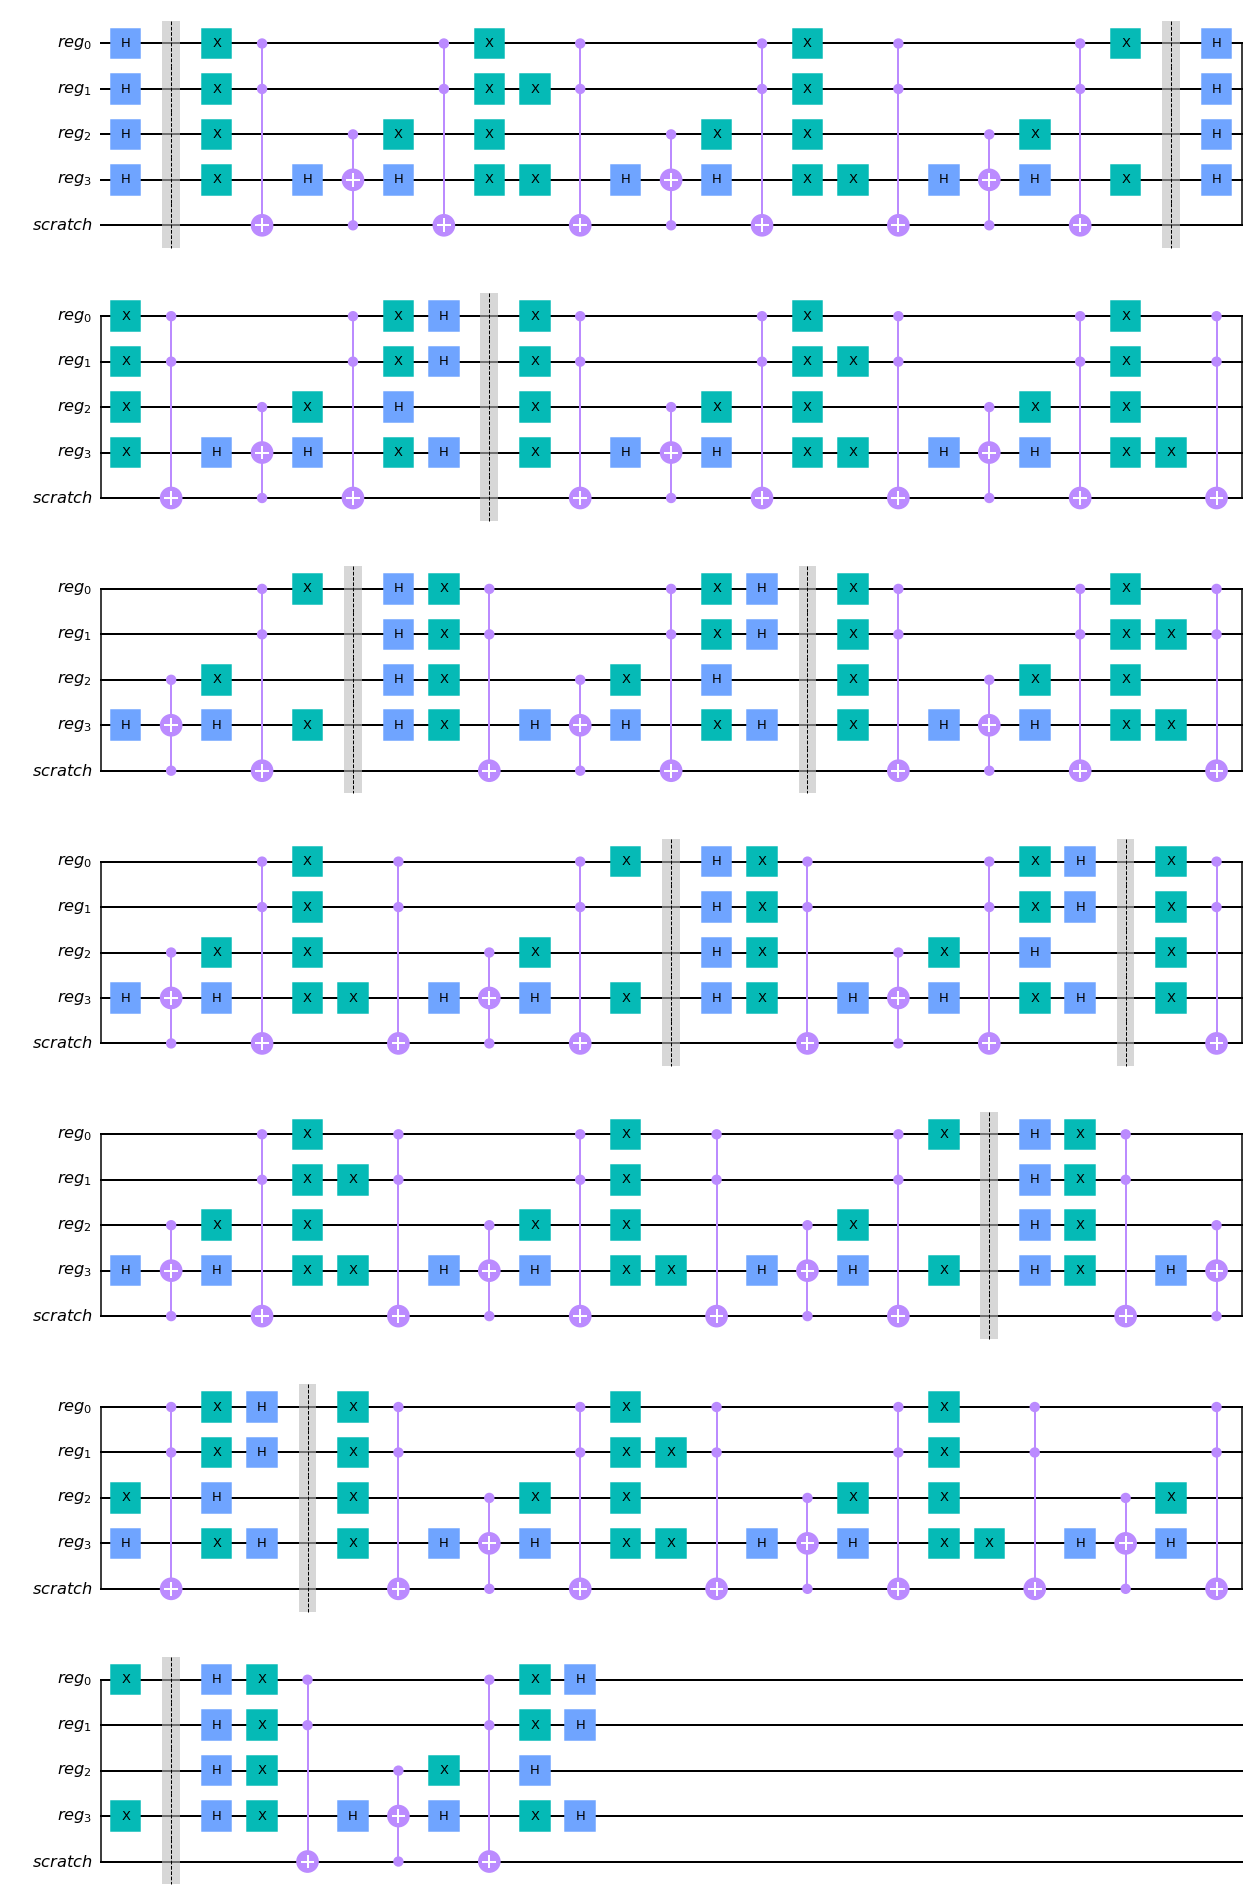

In [9]:
outputstate = result.get_statevector(qc, decimals=3)
total_prob = 0
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        total_prob += prob
        print('|{}> {} probability = {}%'.format(i, amp, round(prob * 100, 5)))
print('Total probability: {}%'.format(int(round(total_prob * 100))))
qc.draw()        # draw the circuit